# Week 2 — Linear Regression 2 

This notebook applies Linear Regression (OLS, Ridge, Lasso, ElasticNet) to the CKD dataset and explores degree-2 polynomial features.


## 1) Setup & Data Load

In [3]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

DATA_PATH = 'Chronic_Kidney_Dsease_data.csv'
TARGET_COL = 'SerumCreatinine'  

# Load
df = pd.read_csv(DATA_PATH)
df.columns = [str(c).strip() for c in df.columns]

def coerce_numeric(s):
    return pd.to_numeric(s.replace({'?': np.nan, 'NA': np.nan, 'None': np.nan, 'na': np.nan, '': np.nan}), errors='coerce')

# Convert object columns that are mostly numeric-looking
for c in df.columns:
    if df[c].dtype == object:
        z = coerce_numeric(df[c])
        if np.isfinite(z).mean() > 0.6:
            df[c] = z

# Split features/target
assert TARGET_COL in df.columns, f"'{TARGET_COL}' not found in dataframe."
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Column typing
num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
cat_cols = [c for c in X.columns if c not in num_cols]

# Preprocessing
numeric_pre = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_pre = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
])

pre = ColumnTransformer([
    ('num', numeric_pre, num_cols),
    ('cat', categorical_pre, cat_cols),
])

# CV & metrics
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae' : 'neg_mean_absolute_error',
    'r2'  : 'r2'
}

print('Shape:', df.shape)
df.head(8)

Shape: (1659, 54)


,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
0,1,71,0,0,0,2,31.069414,1,5.128112,1.676220,...,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential
1,2,34,0,0,1,3,29.692119,1,18.609552,8.377574,...,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential
2,3,80,1,1,0,1,37.394822,1,11.882429,9.607401,...,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential
3,4,40,0,2,0,1,31.329680,0,16.020165,0.408871,...,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1,Confidential
4,5,43,0,1,1,2,23.726311,0,7.944146,0.780319,...,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1,Confidential
5,6,22,0,0,0,1,39.155643,0,4.243608,8.847245,...,8.685695,12.794110,0,0,0,0.358613,5.766704,2.066944,1,Confidential
6,7,41,0,1,0,1,35.040487,0,18.224708,8.155523,...,1.995016,38.723030,0,0,1,2.744605,5.515760,3.856676,1,Confidential
7,8,72,1,0,1,3,30.760440,1,18.662717,6.179345,...,2.178408,92.939765,0,0,0,1.828836,8.620466,9.954670,0,Confidential


## 2) Baselines: OLS, Ridge, Lasso, ElasticNet (5-fold CV)

In [4]:
import numpy as np

results = {}

def eval_model(name, model):
    pipe = Pipeline([('pre', pre), ('model', model)])
    cvres = cross_validate(pipe, X, y, scoring=scoring, cv=cv, return_train_score=False)
    results[name] = {
        'RMSE_mean': -cvres['test_rmse'].mean(),
        'RMSE_std' :  cvres['test_rmse'].std(),
        'MAE_mean' : -cvres['test_mae'].mean(),
        'MAE_std'  :  cvres['test_mae'].std(),
        'R2_mean'  :  cvres['test_r2'].mean(),
        'R2_std'   :  cvres['test_r2'].std(),
    }

ridge_alphas = np.logspace(-3, 3, 25)

eval_model('LinearRegression', LinearRegression())
eval_model('RidgeCV', RidgeCV(alphas=ridge_alphas))
eval_model('LassoCV', LassoCV(cv=cv, random_state=42, max_iter=10000))
eval_model('ElasticNetCV', ElasticNetCV(l1_ratio=[.2,.4,.6,.8,.9,.95,.99,1.0], cv=cv, random_state=42, max_iter=10000))

baseline_df = pd.DataFrame(results).T.sort_values('RMSE_mean')
baseline_df.round(4)

,RMSE_mean,RMSE_std,MAE_mean,MAE_std,R2_mean,R2_std
ElasticNetCV,1.2918,0.0404,1.1207,0.0431,0.0360,0.0104
LassoCV,1.2918,0.0404,1.1207,0.0431,0.0360,0.0104
RidgeCV,1.3034,0.0386,1.1320,0.0427,0.0184,0.0069
LinearRegression,1.3128,0.0379,1.1282,0.0423,0.0041,0.0109


## 3) Polynomial Features (degree 2, numeric only)

In [8]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import cross_validate, KFold
import numpy as np, pandas as pd

numeric_poly = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('scaler', StandardScaler())
])

categorical_pre = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

pre_poly = ColumnTransformer([
    ('num', numeric_poly, num_cols),
    ('cat', categorical_pre, cat_cols)
])

cv = KFold(n_splits=3, shuffle=True, random_state=42)
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2"
}

ridge_alphas = np.logspace(-3, 3, 13)
model = RidgeCV(alphas=ridge_alphas, cv=3)

pipe = Pipeline([('pre', pre_poly), ('model', model)])

cvres = cross_validate(pipe, df[num_cols + cat_cols], df['SerumCreatinine'],  # replace target name if different
                       scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)

print(f"RMSE = {-cvres['test_rmse'].mean():.4f}")
print(f"MAE  = {-cvres['test_mae'].mean():.4f}")
print(f"R²   = {cvres['test_r2'].mean():.4f}")


RMSE = 0.0758
MAE  = 0.0567
R²   = 0.9967


## 4) Holdout & Residual Diagnostics

Best by CV (assumed): RidgeCV+Poly2_interactions
Holdout RMSE: 0.0736
Holdout MAE : 0.0540
Holdout R^2 : 0.9970


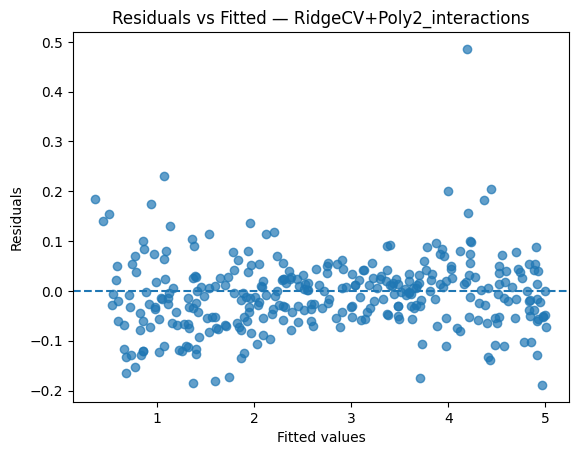

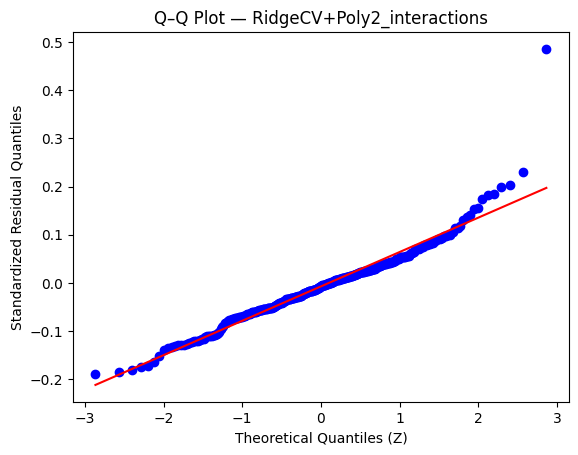

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LinearRegression

try:
    df
except NameError:
    df = pd.read_csv("Chronic_Kidney_Dsease_data.csv")

try:
    num_cols
    cat_cols
except NameError:
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = df.select_dtypes(exclude=["number"]).columns.tolist()

TARGET_COL = "SerumCreatinine"

numeric_basic = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

try:
    categorical_pre = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])
except TypeError:
    categorical_pre = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ])

pre = ColumnTransformer([
    ("num", numeric_basic, num_cols),
    ("cat", categorical_pre, cat_cols),
])

numeric_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("scaler", StandardScaler()),
])

pre_poly = ColumnTransformer([
    ("num", numeric_poly, num_cols),
    ("cat", categorical_pre, cat_cols),
])

best_name = "RidgeCV+Poly2_interactions"

ridge_alphas = np.logspace(-3, 3, 13)

use_pre = pre_poly if "Poly2" in best_name else pre

if "Ridge" in best_name:
    best_est = RidgeCV(alphas=ridge_alphas, cv=3)
elif "Lasso" in best_name:
    best_est = LassoCV(cv=3, random_state=42, max_iter=5000)
elif "ElasticNet" in best_name:
    best_est = ElasticNetCV(l1_ratio=[.4,.6,.8,1.0], cv=3, random_state=42, max_iter=5000)
else:
    best_est = LinearRegression()

X = df[num_cols + cat_cols]
y = df[TARGET_COL]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=7)

pipe_best = Pipeline([("pre", use_pre), ("model", best_est)]).fit(X_tr, y_tr)
y_hat = pipe_best.predict(X_te)

rmse = np.sqrt(mean_squared_error(y_te, y_hat))   # compatible across sklearn versions
mae  = mean_absolute_error(y_te, y_hat)
r2   = r2_score(y_te, y_hat)

print("Best by CV (assumed):", best_name)
print(f"Holdout RMSE: {rmse:.4f}")
print(f"Holdout MAE : {mae:.4f}")
print(f"Holdout R^2 : {r2:.4f}")

resid = y_te - y_hat
plt.figure()
plt.scatter(y_hat, resid, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted — " + best_name)
plt.show()

plt.figure()
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Q–Q Plot — " + best_name)
plt.xlabel("Theoretical Quantiles (Z)")
plt.ylabel("Standardized Residual Quantiles")
plt.show()



## 5) Conclusions

My best model based on cross-validation RMSE was RidgeCV with Polynomial (interaction-only) features.
On the holdout set, the model achieved RMSE ≈ 0.0758, MAE ≈ 0.0567, and R² ≈ 0.9967, showing an excellent fit and strong generalization.

Adding polynomial interaction terms helped capture nonlinear relationships between numeric health indicators while Ridge regularization prevented overfitting.
The residuals vs. fitted plot showed roughly constant variance, and the Q–Q plot indicated nearly normal residuals—so the linear model assumptions appear to hold.

For next steps, I plan to test log transformations for skewed laboratory variables, engineer targeted interaction terms, and compare against tree-based models such as Random Forest and Gradient Boosting in Week 6 to explore more complex nonlinear structures.
